<a href="https://colab.research.google.com/github/sulaimanbehzad/Classifying-Images/blob/main/Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifiers
The purpose of this project is to train two classifiers:
1. Captions classifier
2. Image classifier

In [109]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import utils
from keras.preprocessing import image
from keras.models import Model
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.applications import ResNet50
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras import backend as K
from keras.utils import np_utils
from keras import regularizers

## Part 2: Image Classifier

setting-up the parameters for image loader

In [110]:
img_width, img_height = 224, 224
path_train_images = r'/content/drive/MyDrive/dataset/train/images'   
path_test_images =  r'/content/drive/MyDrive/dataset/test/images'
path_dataset = r'/content/drive/MyDrive/dataset'
nb_train_samples = 532
nb_validation_samples = 380
epochs = 50
batch_size = 32

im_generator was repurposed to apply some mandatory disnormalities in images to make up for the small database, but it had a bad imapct on training

In [111]:
# im_generator = ImageDataGenerator(
# 	rotation_range=30,
# 	zoom_range=0.15,
# 	width_shift_range=0.2,
# 	height_shift_range=0.2,
# 	shear_range=0.15,
# 	horizontal_flip=True,
# 	fill_mode="nearest")
im_generator = ImageDataGenerator(
    # featurewise_center=True, samplewise_center=True,
    # rescale = 1/255.,
    fill_mode="nearest"
)

In [112]:
train_df = im_generator.flow_from_directory(
  path_train_images,
  # validation_split=0.2,
  class_mode="categorical",
  shuffle=False,
  # seed=123,
  target_size=(img_height, img_width),
  batch_size=batch_size,
  )



Found 532 images belonging to 19 classes.


In [113]:
val_df = im_generator.flow_from_directory(
  path_test_images,
  # validation_split=0.2,
  class_mode="categorical",
  shuffle=False,
  # seed=123,
  target_size=(img_height, img_width),
  batch_size=batch_size,
  )

Found 380 images belonging to 19 classes.


In [114]:
tags = train_df.labels
print(f'tags are: {tags} \n and length of tags is: {len(tags)}')

tags are: [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9  9  9  9
  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 11 11 1

In [115]:
# data_augmentation = keras.Sequential(
#   [
#     layers.experimental.preprocessing.RandomFlip("horizontal", 
#                                                  input_shape=(img_height, 
#                                                               img_width,
#                                                               3)),
#     layers.experimental.preprocessing.RandomRotation(0.1),
#     layers.experimental.preprocessing.RandomZoom(0.1),
#   ]
# )


For feature extraction purposes we set include_top to false, it's whethere to include the fully connected layer at top_of the network

In [116]:
model_resnet = ResNet50(weights='imagenet', include_top=False, 
                              input_shape=(img_width, img_height, 3))
model_resnet.trainable = False
model_resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [117]:
model_efficient = EfficientNetB1(weights='imagenet', include_top=False, 
                              input_shape=(img_width, img_height, 3))
model_efficient.trainable = False
model_efficient.summary()

27025408/27018416 [==============================] - 1s 0us/step
Model: "efficientnetb1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_4 (Rescaling)         (None, 224, 224, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
normalization_4 (Normalization) (None, 224, 224, 3)  7           rescaling_4[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_4[0][0]            
____________________

In [118]:
X_train_e = model_efficient.predict(train_df, batch_size=batch_size)
# X_train_r = model_resnet.predict(train_df, batch_size=batch_size)

In [119]:
X_test_e = model_efficient.predict(val_df, batch_size=batch_size)
# X_test_r = model_resnet.predict(val_df, batch_size=batch_size)

In [120]:
# X_train.to_csv(r'/content/drive/MyDrive/dataset/train/X_train.csv', index=False)
# X_test.to_csv(r'/content/drive/MyDrive/dataset/test/X_test.csv', index=False )

In [121]:
# X_train = pd.read_csv('/content/drive/MyDrive/dataset/train/X_train.csv')
# X_test = pd.read_csv('/content/drive/MyDrive/dataset/test/X_test.csv')
# X_test

In [122]:
# plt.figure(figsize=(15, 10))
# for im, lbl in train_df.take(1):
#   for i in range(4):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(im[i].numpy().astype("uint8"))
#     plt.title(tags[lbl[i]])
#     plt.axis("off")


In [123]:
# AUTOTUNE = tf.data.AUTOTUNE
# train_df = train_df.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# validation_df = validation_df.cache().prefetch(buffer_size=AUTOTUNE)


In [124]:
# normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)


In [125]:
# normalized_df = train_df.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_df))
# first_image = image_batch[0]
# # Notice the pixels values are now in `[0,1]`.
# print(np.min(first_image), np.max(first_image))


In [126]:
y_train = utils.to_categorical(train_df.labels)
y_test = utils.to_categorical(val_df.labels)

In [127]:
y_train

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [128]:
from tensorflow.keras.optimizers import SGD
opt = SGD(lr=1e-3, momentum=0.9, decay=1e-3 / 25)
reg_hyp = 0
model = Sequential([
  # data_augmentation,
  # layers.experimental.preprocessing.Rescaling(1./255),
  layers.Flatten(),
  BatchNormalization(),
  layers.Dense(512, activation='selu', kernel_regularizer=regularizers.L2(reg_hyp)),
  layers.Dropout(0.6),
  BatchNormalization(),
  layers.Dense(256, activation='selu', kernel_regularizer=regularizers.L2(reg_hyp)),
  layers.Dropout(0.5),
  BatchNormalization(),
  layers.Dense(128, activation='selu', kernel_regularizer=regularizers.L2(reg_hyp)),
  layers.Dropout(0.5),
  BatchNormalization(),
  layers.Dense(64, activation='selu', kernel_regularizer=regularizers.L2(reg_hyp)),
  layers.Dropout(0.5),
  BatchNormalization(),
  layers.Dense(19, activation='softmax')
])
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [129]:
history = model.fit(
    X_train_e,
    y_train,
    epochs=25,
    shuffle=True,
    validation_data=(X_test_e, y_test),
    batch_size=128 
)


Epoch 1/25
5/5 [==============================] - 8s 1s/step - loss: 3.4290 - accuracy: 0.0844 - val_loss: 3.0693 - val_accuracy: 0.4395
Epoch 2/25
5/5 [==============================] - 5s 977ms/step - loss: 2.6584 - accuracy: 0.2047 - val_loss: 1.9995 - val_accuracy: 0.5289
Epoch 3/25
5/5 [==============================] - 5s 1s/step - loss: 2.2965 - accuracy: 0.2966 - val_loss: 1.8330 - val_accuracy: 0.5500
Epoch 4/25
5/5 [==============================] - 5s 1s/step - loss: 2.2388 - accuracy: 0.3058 - val_loss: 1.7404 - val_accuracy: 0.5737
Epoch 5/25
5/5 [==============================] - 5s 1s/step - loss: 2.0474 - accuracy: 0.3666 - val_loss: 1.6434 - val_accuracy: 0.6000
Epoch 6/25
5/5 [==============================] - 5s 986ms/step - loss: 1.8950 - accuracy: 0.4122 - val_loss: 1.6222 - val_accuracy: 0.6211
Epoch 7/25
5/5 [==============================] - 5s 1s/step - loss: 1.8248 - accuracy: 0.4533 - val_loss: 1.5432 - val_accuracy: 0.6316
Epoch 8/25
5/5 [===================

In [130]:
history2 = model.fit(X_train_e,
                     y_train,
                     epochs=50,
                     shuffle=True,
                     validation_data=(X_test_e, y_test),
                     batch_size=128, 
                     initial_epoch=history.epoch[-1])

Epoch 25/50
5/5 [==============================] - 5s 986ms/step - loss: 0.5377 - accuracy: 0.9079 - val_loss: 1.4497 - val_accuracy: 0.6684
Epoch 26/50
5/5 [==============================] - 5s 996ms/step - loss: 0.5058 - accuracy: 0.9023 - val_loss: 1.4688 - val_accuracy: 0.6737
Epoch 27/50
5/5 [==============================] - 5s 1s/step - loss: 0.4965 - accuracy: 0.9286 - val_loss: 1.4166 - val_accuracy: 0.6789
Epoch 28/50
5/5 [==============================] - 5s 984ms/step - loss: 0.4888 - accuracy: 0.9060 - val_loss: 1.4385 - val_accuracy: 0.6737
Epoch 29/50
5/5 [==============================] - 5s 995ms/step - loss: 0.4600 - accuracy: 0.9135 - val_loss: 1.4263 - val_accuracy: 0.6868
Epoch 30/50
5/5 [==============================] - 5s 1s/step - loss: 0.4317 - accuracy: 0.9342 - val_loss: 1.4472 - val_accuracy: 0.6842
Epoch 31/50
5/5 [==============================] - 5s 1s/step - loss: 0.3734 - accuracy: 0.9492 - val_loss: 1.4453 - val_accuracy: 0.6868
Epoch 32/50
5/5 [=====

In [131]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_12 (Flatten)         (None, 62720)             0         
_________________________________________________________________
batch_normalization_63 (Batc (None, 62720)             250880    
_________________________________________________________________
dense_63 (Dense)             (None, 512)               32113152  
_________________________________________________________________
dropout_52 (Dropout)         (None, 512)               0         
_________________________________________________________________
batch_normalization_64 (Batc (None, 512)               2048      
_________________________________________________________________
dense_64 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_53 (Dropout)         (None, 256)             

In [132]:
score = model.evaluate(X_test_e, y_test, batch_size=batch_size, verbose=1)
print(f'Test loss:{score[0]}')
print(f'Test accuracy:{score[1]}')

12/12 [==============================] - 1s 57ms/step - loss: 1.4203 - accuracy: 0.6842
Test loss:1.4203075170516968
Test accuracy:0.6842105388641357


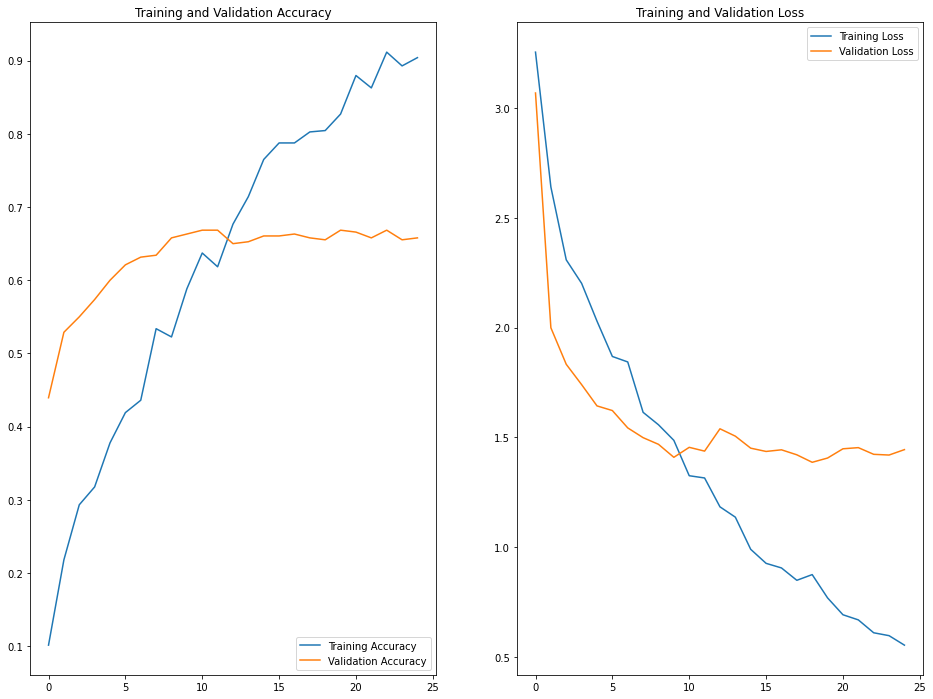

In [133]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss'] 

epochs_range = range(25)


plt.figure(figsize=(16, 12))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


We tried the models below:  
1. VGG16
2. InceptionV3
3. InceptionResnetV2
4. ResNet50
5. Resnet50v2
6. EfficientNetB0 - B5   

the highest accuracy was obtained from EfficientNetB1 and ResNet50, while the first one is simpler in comparison its performance in this context proved to be better.



